# Merge Trees and Decorated Merge Trees

This notebook illustrates some of the basic functionality of our merge tree and decorated merge tree (DMT) analysis framework. The main paper describing this framework is 

[1] *Decorated Merge Trees for Persistenct Topology* by Justin Curry, Haibin Hang, Washington Mio, Tom Needham and Osman Okutan. [Arxiv](https://arxiv.org/abs/2103.15804). The paper has been published in [Journal of Applied and Computational Topology](https://link.springer.com/article/10.1007/s41468-022-00089-3).

We will refer back to specific sections of this paper throughout the notebook. Other notebooks in the GitHub repo show more involved examples and can be used to recreate the figures and experiments in the paper.

This notebook will be focused on creating and visualizing merge trees and DMTs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
import persim
import networkx as nx
import random
from scipy.optimize import linear_sum_assignment
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.metrics.pairwise import pairwise_distances

from DMT_tools import *

import ot

import time

import warnings
warnings.filterwarnings("ignore")

## Merge Trees

Our code includes functions for creating, visualizing and comparing merge trees. The creation and visualization  functionality is demonstrated below.

### Creating Merge Trees

A *merge tree* is a rooted tree with heights assigned to its nodes. Every non-root node $v$ must have exactly one neighbor whose height is strictly greater than the height of $v$. Merge trees are represented as pairs `T`, `height` containing the graph structure---as a `networkx` graph---and the height function---as a dictionary with keys equal to the node labels of the tree. This is data is stored together in a `MergeTree` class.

The code below creates merge trees by directly specifying their combinatorial structure. Later we will see methods for generating merge trees automatically from point clouds or filtered networks.

In [2]:
# Initializing data
T1=nx.Graph()
T1.add_nodes_from(list(range(6)))
T1.add_edges_from([(0,4),(1,3),(2,3),(3,4),(4,5)])
height1 = {0:0,1:0,2:2,3:3,4:5,5:7}

T2 = nx.Graph()
T2.add_nodes_from(list(range(4)))
T2.add_edges_from([(0,2),(1,2),(2,3)])
height2 = {0:0,1:0,2:5,3:7}

# Creating merge tree classes
MT1 = MergeTree(tree = T1, height = height1)
MT2 = MergeTree(tree = T2, height = height2)

The tree structure or node heights can be recovered from the class:

{0: 0, 1: 0, 2: 2, 3: 3, 4: 5, 5: 7}


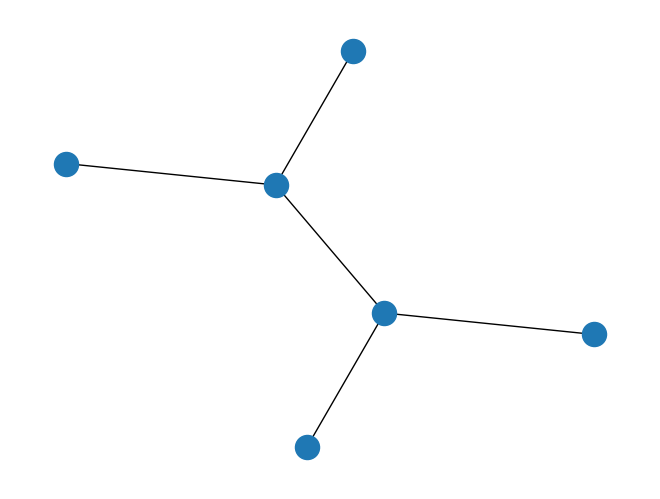

In [3]:
print(MT1.height)

nx.draw_kamada_kawai(MT1.tree)

### Visualizing Merge Trees

We can plot the merge trees we created above according to their height data.

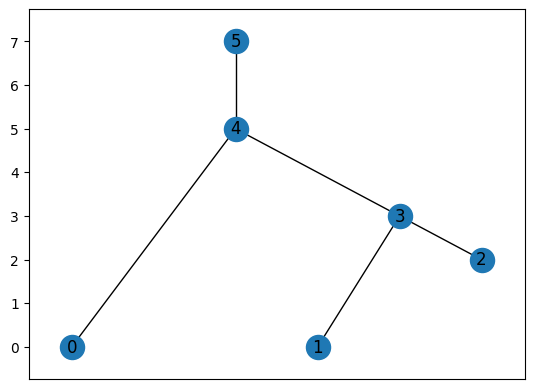

In [4]:
MT1.draw(axes = True)

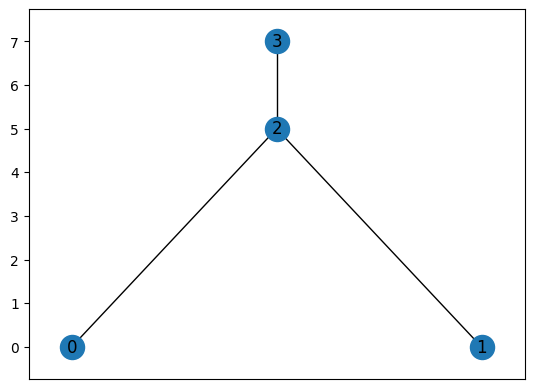

In [5]:
MT2.draw(axes = True)

### Estimating Merge Tree Interleaving Distance

One can define a metric on the space of merge trees called *interleaving distance* which is inspired by bottleneck distance between persistence diagrams (see *Interleaving distance between merge trees* by Morozov et al., 2013 or Section 4.3 of [1]). Interleaving distance is not tractable to compute exactly, but we introduce a method to estimate it by using Gromov-Wasserstein distance from optimal transport theory (see Section 6.5 of [1]). 

To improve the accuracty, the user can subdivide the merge trees by specifying a mesh. Generally, a smaller mesh yields a more accurate distance, but a finer mesh incurs a higher computational cost. 

In [6]:
mesh = 0.5
res = merge_tree_interleaving_distance(MT1,MT2,mesh,verbose = False)
print('Estimated Interleaving Distance:',res)

Estimated Interleaving Distance: 1.0


The distance computation can return several outputs, which can be used to visualize the way that the distance computation works. To get more informative output, set `verbose = True`.

In [7]:
mesh = 0.5
res = merge_tree_interleaving_distance(MT1,MT2,mesh,verbose = True)
print(res)

{'coupling': array([[0.03703704, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.03703704, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01777778, 0.        ,
        0.01925926, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0


The 'coupling' key in the dictionary `res` returns a probabilistic matching between the nodes of the subdivided trees.

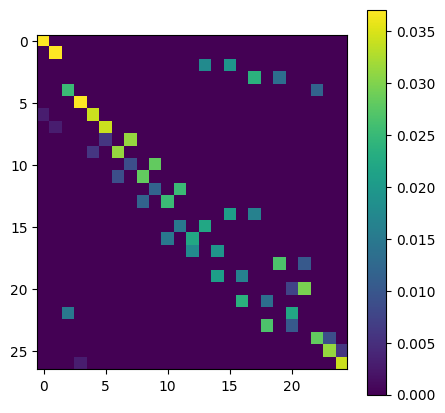

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(res['coupling'])
plt.colorbar()
plt.show()

The distance computation proceeds by estimating an 'optimal labeling' of the merge trees from the coupling. The 'labeling' approach to merge tree interleaving was introduced in Gasparovic et al., *Intrinsic interleaving distance for merge trees*, 2019. 

The labeling can be visualized as shown below. To display it, we should tell the interleaving distance to return the subdivided trees as well as a verbose results output.

Nodes with the same label across the two merge trees in the figure below should be thought of as 'structurally matched'.

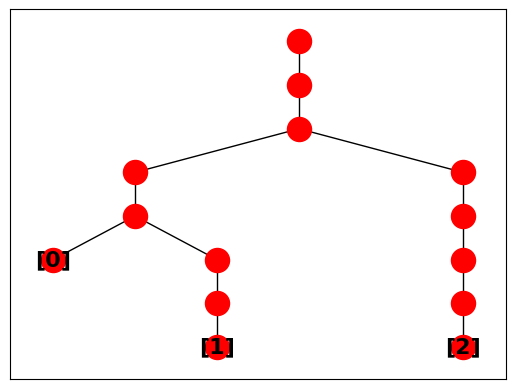

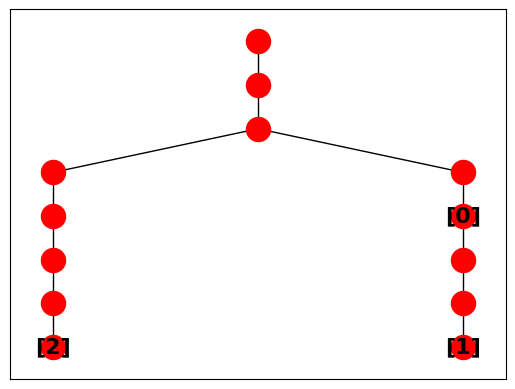

In [9]:
mesh = 1
MT1_sub, MT2_sub, res = merge_tree_interleaving_distance(MT1,MT2,mesh,verbose = True,return_subdivided = True)

MT1_sub.draw_with_labels(res['label1'])
plt.show()
MT2_sub.draw_with_labels(res['label2'])
plt.show()

In [10]:
res['dist']

1.0

### Creating a Merge Tree from Data

Generally, we would be generating merge trees from a dataset. Let's start with a toy dataset consisting of a point cloud in 2D. We'll write some functions to generate random point clouds with topological structure.

In [11]:
def noisy_circle(n_samples, noise_level, center_x, center_y ,radius):

    t = np.linspace(0,2*np.pi,n_samples)
    x = center_x + radius*np.cos(t)
    y = center_y + radius*np.sin(t)
    noise = np.random.rand(n_samples,2)
    data = np.array([x,y]).T + noise_level*radius*noise

    return data

def noisy_disk(n_samples,noise_level,center_x,center_y,radius):

    t = np.linspace(0,2*np.pi,n_samples)
    r = radius*np.random.rand(n_samples)
    x = center_x + np.multiply(r,np.cos(t))
    y = center_y + np.multiply(r,np.sin(t))
    noise = np.random.rand(n_samples,2)
    data = np.array([x,y]).T + noise_level*radius*noise

    return data

def one_disk_two_circles(radii, separation, n_samples_per_shape = 50, noise_level = 0.5, centersy = None):
    
    """
    This example produces one disk and two circles or radii r1,r2,r3. The circles are clustered together and 
    the disk is separated in the x-direction by `separation`
    In: triple of radii = [r1,r2,r3], separation distance
    """
    
    data = np.zeros([n_samples_per_shape*3,2])
    
    shapes = ['disk','circle','circle']
    r1 = radii[0]
    r2 = radii[1]
    r3 = radii[2]
    centersx = [0,r1+separation+r2,r1+separation+2*r2+r3]
    
    if centersy is None:
        centersy = [0,0,0]
    
    num_shapes = len(shapes)
    
    for j in range(num_shapes):
        if shapes[j] == 'disk':
            shape = noisy_disk(n_samples_per_shape,noise_level,centersx[j],centersy[j],radii[j])
        elif shapes[j] == 'circle':
            shape = noisy_circle(n_samples_per_shape, noise_level,centersx[j],centersy[j],radii[j])
        data[j*n_samples_per_shape:(j+1)*n_samples_per_shape,:] = shape
        
    return data

def three_circles(radii, separation1, separation2, n_samples_per_shape = 50, noise_level = 0.5, centersy = None):
    
    
    data = np.zeros([n_samples_per_shape*3,2])
    
    shapes = ['circle','circle','circle']
    r1 = radii[0]
    r2 = radii[1]
    r3 = radii[2]
    centersx = [0,r1+separation1+r2,r1+separation1+r2]
    
    if centersy is None:
        centersy = [0,0,r2+separation2+r3]
    
    num_shapes = len(shapes)
    
    for j in range(num_shapes):
        if shapes[j] == 'disk':
            shape = noisy_disk(n_samples_per_shape,noise_level,centersx[j],centersy[j],radii[j])
        elif shapes[j] == 'circle':
            shape = noisy_circle(n_samples_per_shape, noise_level,centersx[j],centersy[j],radii[j])
        data[j*n_samples_per_shape:(j+1)*n_samples_per_shape,:] = shape
        
    return data

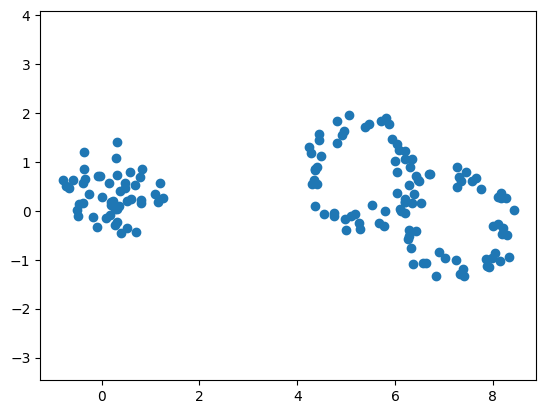

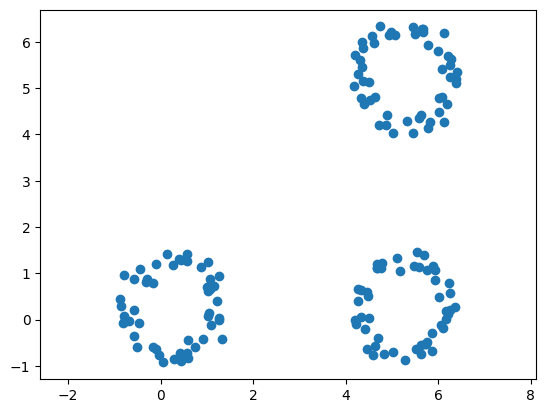

In [12]:
data1 = one_disk_two_circles([1,1,1],3,centersy = [0,0.5,-0.5])

plt.scatter(data1[:,0],data1[:,1])
plt.axis('equal')
plt.show()

data2 = three_circles([1,1,1],3,3)

plt.scatter(data2[:,0],data2[:,1])
plt.axis('equal')
plt.show()

Now we create a merge tree by tracking merging of connected components in the Vietoris-Rips complexes as the parameter increases. The result is also known as a **single linkage hierarchical clustering dendrogram**. Passing a point cloud matrix into the merge tree class produces the merge tree.

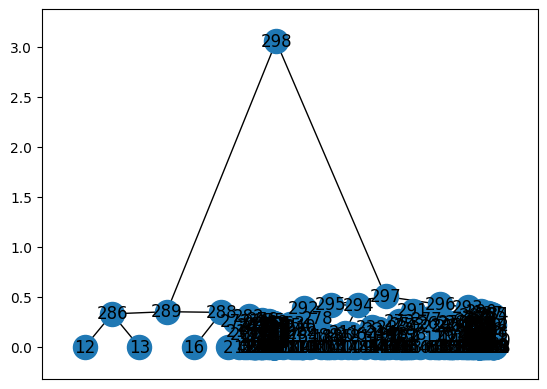

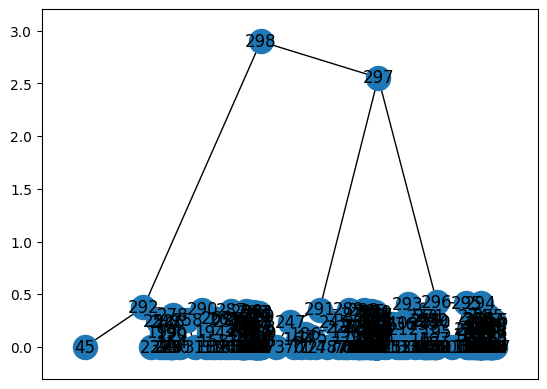

In [13]:
MT1 = MergeTree(pointCloud = data1)
MT2 = MergeTree(pointCloud = data2)

MT1.draw(axes = True)
plt.show()
MT2.draw(axes = True)

### Simplifying Merge Trees

The merge trees shown above are quite complicated. We can get simplified versions by slicing at a given height and merging all nodes below the threshold height to a single node at height zero (more generally, at the lowest leaf height below the threshold point in each branch). This is akin to throwing away bars in a barcode with sufficiently low persistence. The resulting visualizations are much easier to parse and the simplification improves computation time for computing interleaving distance.

The code below performes this simplification at a user-defined threshold height.

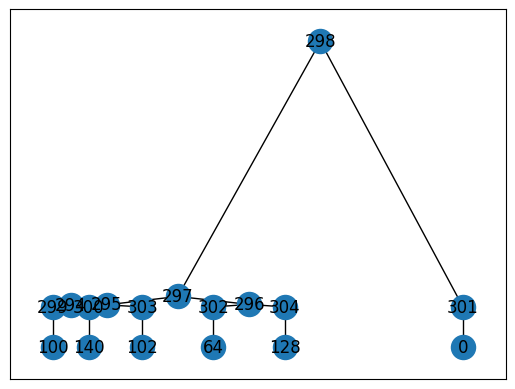

In [14]:
thresh = 0.4

MT1.threshold(thresh)
MT1.draw()

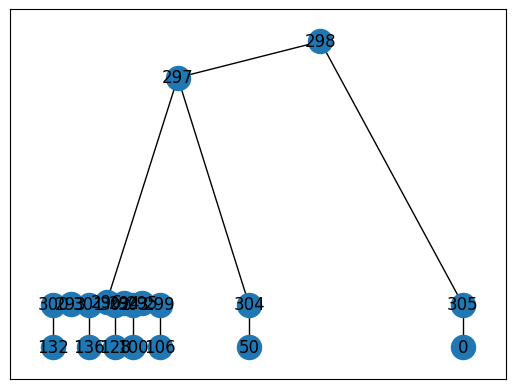

In [15]:
MT2.threshold(thresh)
MT2.draw()

### Simple Distance Comparison

Let's check qualitatively that our estimation of merge tree interleaving distance is able to distinguish between the classes that we've defined above.

The hyperparameters in the experiment are `threshold`, which controls the height at which the trees are truncated, and `mesh`, which controls how densely the trees are upsampled. Both have an effect on compute time. We've observed experimentally that simplifying by thresholding doesn't tend to degrade results, and sometimes improves accuracy.

Creating Data...
Computing Pairwise Distances...
row= 0
row= 1
row= 2
row= 3


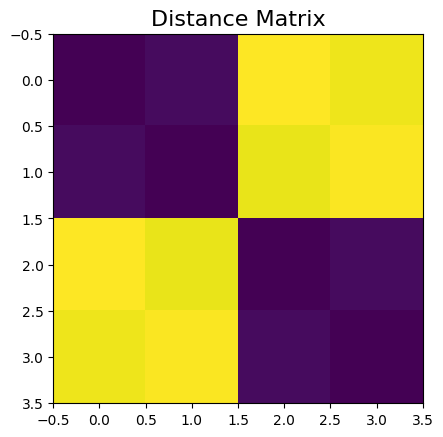

CPU times: user 340 ms, sys: 209 ms, total: 549 ms
Wall time: 326 ms


In [16]:
%%time

# Hyperparameters
threshold = 1
mesh = 1


# Create dataset of 2 samples for each of the two classes
print('Creating Data...')
point_clouds = [one_disk_two_circles([1,1,1],3,centersy = [0,0.5,-0.5]),
               one_disk_two_circles([1,1,1.1],3,centersy = [0,0.5,-0.5]),
                three_circles([1,1,1],3,3),
                three_circles([1,1,1.1],3,3)]

MTs = []

for point_cloud in point_clouds:
    MT = MergeTree(pointCloud = point_cloud)
    MT.threshold(threshold)
    MTs.append(MT)
    
# Compute a 4x4 pairwise distance matrix

print('Computing Pairwise Distances...')
distMat = np.zeros([4,4])

for i in range(4):
    print('row=',i)
    MTi = MTs[i]
    for j in range(i+1,4):
        MTj = MTs[j]
        distMat[i,j] = merge_tree_interleaving_distance(MTi,MTj,mesh,verbose = False)
        
distMat += distMat.T

plt.imshow(distMat)
plt.title('Distance Matrix',fontsize = 16)
plt.show()

## Decorated Merge Trees (DMTs)

Decorated Merge Trees fuse persistent connectivity data (the merge tree) with higher dimensional persistent homological data (barcodes).

### Creating DMTs from Data

The code below creates a DMT from the first dataset created above. Specifically, it creates a *Barcode Decorated Merge Tree* from Section 3.3 of [1]. This attaches a barcode to each leaf of the merge tree.

In this example, we are attaching a degree-1 persistent homology barcode to each leaf of the merge tree. The persistent homology computation is handled by `ripser`.

The process of decorating a merge tree is handled within the class by the `fit_barcode` method. The degree of the barcode should be specified and the persistent homology computation is handled within the fitting process.

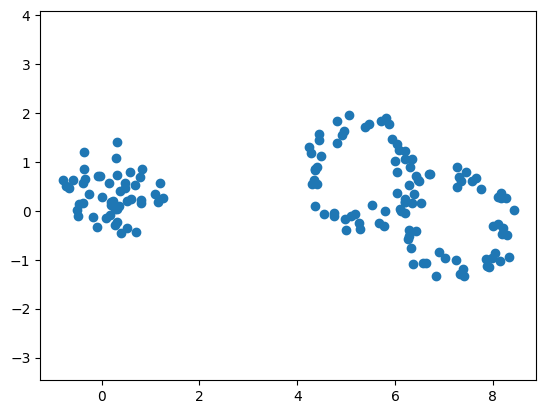

In [17]:
plt.scatter(data1[:,0],data1[:,1])
plt.axis('equal')
plt.show()

In [18]:
MT1 = MergeTree(pointCloud = data1)
MT1.fit_barcode(degree = 1)

The barcodes attached to the leaves of the merge tree are accessed by the `leaf_barcode` attribute. The leaf barcode is a dictionary of the form {node_id:barcode}, where the barcode is a list of bars (each bar is a list with two elements).

In [19]:
MT1.leaf_barcode

{0: [[0.4241871237754822, 0.4761469066143036],
  [0.30916890936225255, 0.4500880241394043],
  [0.30916890936225255, 0.4393116533756256],
  [0.30916890936225255, 0.3270774781703949]],
 1: [[0.4241871237754822, 0.4761469066143036],
  [0.30916890936225255, 0.4500880241394043],
  [0.30916890936225255, 0.4393116533756256],
  [0.30916890936225255, 0.3270774781703949]],
 2: [[0.4241871237754822, 0.4761469066143036],
  [0.30916890936225255, 0.4500880241394043],
  [0.30916890936225255, 0.4393116533756256],
  [0.30916890936225255, 0.3270774781703949]],
 3: [[0.4241871237754822, 0.4761469066143036],
  [0.32098594307899475, 0.3693012297153473],
  [0.30711373686790466, 0.4500880241394043],
  [0.2848455607891083, 0.4393116533756256],
  [0.25824299454689026, 0.26405754685401917],
  [0.25299522280693054, 0.29305219650268555],
  [0.22061152756214142, 0.23619623482227325]],
 4: [[0.4241871237754822, 0.4761469066143036],
  [0.32098594307899475, 0.3693012297153473],
  [0.30711373686790466, 0.4500880241394

### Simplifying DMTs

When we simplify a merge tree, as describe above, we can also simplify the leaf decorations. The leaves in the simplified merge tree keep their associated barcode computed above. This is once again handled by the `threshold` method.

In [20]:
threshold = 0.5

MT1_thresh = MT1.copy()
MT1_thresh.threshold(threshold)

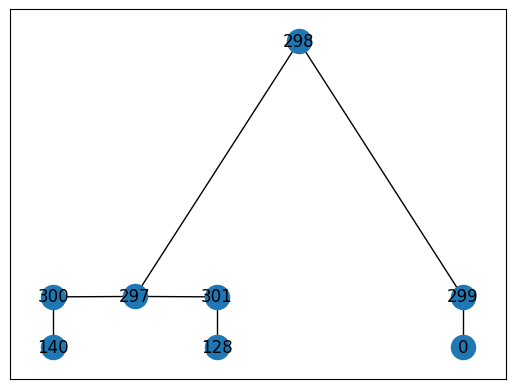

In [21]:
MT1_thresh.draw()

In [22]:
MT1_thresh.leaf_barcode

{0: [[0.4241871237754822, 0.4761469066143036],
  [0.30916890936225255, 0.4500880241394043],
  [0.30916890936225255, 0.4393116533756256],
  [0.30916890936225255, 0.3270774781703949]],
 140: [[0.560986340045929, 1.396588683128357],
  [0.5045542931102499, 1.4550864696502686]],
 128: [[0.560986340045929, 1.396588683128357],
  [0.4467279314994812, 1.4550864696502686],
  [0.406066358089447, 0.4616299569606781]]}

The two apparent loops in the dataset should be represented by two long bars attached to a leaf (or to several leaves which merge at a relatively low height). This corresponds to the two loops lying in a single connected component.

### Visualizing DMTs

We can visualize our DMT by enriching the merge tree with overlaid barcodes. This corresponds to the 'lift decoration' process described in Section 5.4 of [1]. 

To get a nice looking picture, we only include bars whose persistence is larger than a given threshold. Now there are two parameters involved in visualizing a DMT: the height at which to truncate the tree and the persistence of bars that we want to display overlaid on the tree.

We can predetermine a good threshold for persistence of bars by visualizing the persistence diagram. We use the `persim` package and plot in 'lifetime' mode, so that the persistence of a bar is more apparent. The barcode for the merge tree is stored as an attribute.

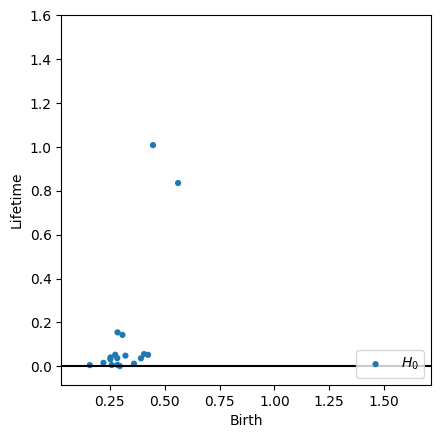

In [23]:
persim.plot_diagrams(MT1.barcode,lifetime = True)

The `draw_decorated` method takes thresholds as inputs and produces the following figure. Note that the rendering process can take a while if the merge tree is very complicated. 

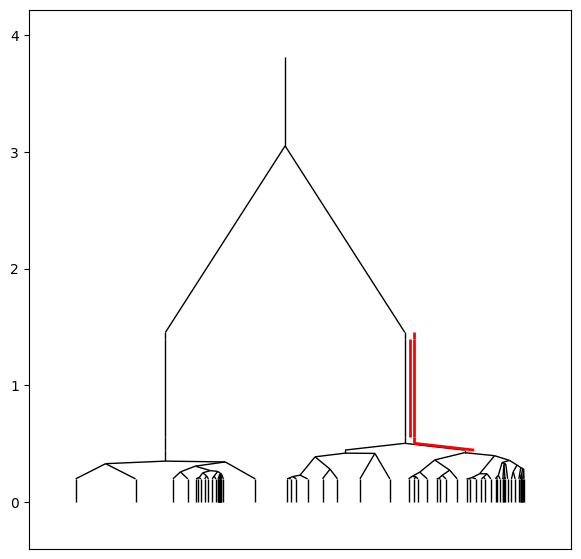

In [24]:
tree_thresh = 0.2
barcode_thresh = 0.4

MT1.draw_decorated(tree_thresh,barcode_thresh)

Observe that the DMT simultaneously illustrates the connected component and loops structure of the dataset, together with how these structures interact!

Here is a code block to draw a DMT for the second dataset defined above, using the same thresholds as for `data1`.

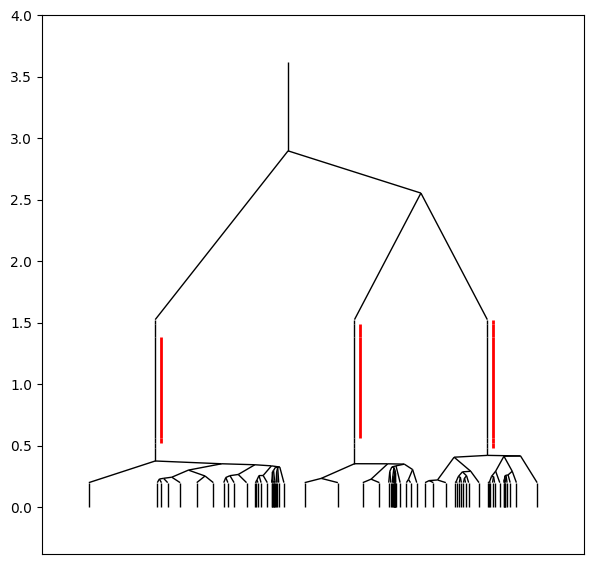

In [25]:
MT2 = MergeTree(pointCloud = data2)
MT2.fit_barcode(degree = 1)
MT2.draw_decorated(tree_thresh,barcode_thresh)

### Comparing DMTs

Decorated merge trees can be compared using the decorated bottleneck distance defined in Section 4.5 of [1]. We can estimate this distance using a variant of Gromov-Wasserstein distance called [Fused Gromov-Wasserstein Distance](https://arxiv.org/abs/1811.02834). This involves another parameter $\alpha$, which balances the weight of degree-0 vs. higher degree homology when finding a merge tree interleaving. 

Details and more examples will be provided in a followup notebook. The basic syntax for computing the distance is shown below. It is computationally beneficial to simplify the merge tree (as above) before computing the distance. This distance computation is currently usable, but is **not yet optimized**---faster versions of this algorithm will be included in future updates to the repository.

In [26]:
MT1_thresh = MT1.copy()
MT1_thresh.threshold(0.4)
MT2_thresh = MT2.copy()
MT2_thresh.threshold(0.4)

res = DMT_interleaving_distance(MT1_thresh,MT2_thresh,1,verbose = True)

print('The estimated decorated bottleneck distance is:', res)

The estimated decorated bottleneck distance is: {'coupling': array([[1.44985355e-10, 1.38159577e-04, 1.65791655e-02, 5.52638851e-16,
        5.52638851e-16, 8.28958276e-16, 9.25670079e-03, 8.28958276e-16,
        8.28958276e-16, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
        8.28958276e-16, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
        1.65791655e-15, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
        5.88974855e-13, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
        8.28958276e-16, 8.28958276e-16],
       [5.52638851e-16, 5.52638851e-16, 4.69743028e-03, 2.12765957e-02,
        5.52638851e-16, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
        8.28958276e-16, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
        8.28958276e-16, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
        1.65791655e-15, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
        2.57225753e-12, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
        8.28958276e-16, 8.28958276

In [27]:
res

{'coupling': array([[1.44985355e-10, 1.38159577e-04, 1.65791655e-02, 5.52638851e-16,
         5.52638851e-16, 8.28958276e-16, 9.25670079e-03, 8.28958276e-16,
         8.28958276e-16, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
         8.28958276e-16, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
         1.65791655e-15, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
         5.88974855e-13, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
         8.28958276e-16, 8.28958276e-16],
        [5.52638851e-16, 5.52638851e-16, 4.69743028e-03, 2.12765957e-02,
         5.52638851e-16, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
         8.28958276e-16, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
         8.28958276e-16, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
         1.65791655e-15, 1.65791655e-15, 1.65791655e-15, 1.65791655e-15,
         2.57225753e-12, 8.28958276e-16, 8.28958276e-16, 8.28958276e-16,
         8.28958276e-16, 8.28958276e-16],
        [5.52638851e-16, 5.5

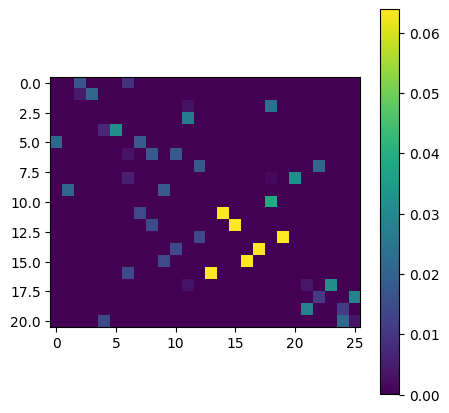

In [28]:
plt.figure(figsize = (5,5))
plt.imshow(res['coupling'])
plt.colorbar()
plt.show()